# 🤖 AI-Powered Data Cleaning Agent - Colab Demo

**GenAI Competition - UoM DSCubed x UWA DSC**  
**Author:** Rudra Tiwari  

This notebook demonstrates how to use the DataCleaningAgent in Google Colab.

## 🚀 Quick Start Guide:
1. **Upload your data** using the file uploader below
2. **Run the cleaning agent** with one line of code
3. **Download your cleaned data** automatically

Let's get started! 🎉


## Step 1: Install Required Packages


In [1]:
# Install required packages
%pip install pandas numpy matplotlib seaborn openpyxl -q

print("✅ All packages installed successfully!")


✅ All packages installed successfully!


## Step 2: Create the DataCleaningAgent Class


In [2]:
# Create the DataCleaningAgent class directly in the notebook
import pandas as pd
import numpy as np
from typing import Dict, List, Any, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

class DataCleaningAgent:
    """
    AI-Powered Data Cleaning Agent
    Provides intelligent data cleaning with comprehensive analysis
    """

    def __init__(self):
        self.cleaning_history = []
        self.data_quality_report = {}
        self.cleaning_suggestions = []

    def analyze_data_quality(self, df: pd.DataFrame) -> Dict[str, Any]:
        """Comprehensive data quality analysis"""
        print("🔍 Analyzing Data Quality...")

        analysis = {
            'shape': df.shape,
            'columns': list(df.columns),
            'data_types': df.dtypes.to_dict(),
            'missing_values': df.isnull().sum().to_dict(),
            'missing_percentage': (df.isnull().sum() / len(df) * 100).to_dict(),
            'duplicate_rows': df.duplicated().sum(),
            'duplicate_percentage': (df.duplicated().sum() / len(df) * 100),
            'memory_usage': df.memory_usage(deep=True).sum(),
            'numeric_columns': df.select_dtypes(include=[np.number]).columns.tolist(),
            'categorical_columns': df.select_dtypes(include=['object']).columns.tolist(),
            'datetime_columns': df.select_dtypes(include=['datetime64']).columns.tolist()
        }

        # Detect potential issues
        issues = []
        if analysis['missing_percentage']:
            high_missing = {col: pct for col, pct in analysis['missing_percentage'].items() if pct > 50}
            if high_missing:
                issues.append(f"High missing values (>50%): {high_missing}")

        if analysis['duplicate_percentage'] > 10:
            issues.append(f"High duplicate rate: {analysis['duplicate_percentage']:.1f}%")

        analysis['issues'] = issues
        self.data_quality_report = analysis

        return analysis

    def clean_missing_values(self, df: pd.DataFrame, strategy: str = 'auto') -> pd.DataFrame:
        """Clean missing values with intelligent strategies"""
        print(f"🧹 Cleaning Missing Values using {strategy} strategy...")

        df_cleaned = df.copy()
        changes_made = []

        for column in df_cleaned.columns:
            missing_count = df_cleaned[column].isnull().sum()
            if missing_count > 0:
                if strategy == 'auto':
                    # Intelligent strategy selection
                    if df_cleaned[column].dtype in ['int64', 'float64']:
                        try:
                            if df_cleaned[column].skew() > 1:
                                fill_value = df_cleaned[column].median()
                                method = 'median'
                            else:
                                fill_value = df_cleaned[column].mean()
                                method = 'mean'
                        except:
                            fill_value = 0
                            method = 'zero_fill'
                    else:
                        fill_value = df_cleaned[column].mode().iloc[0] if not df_cleaned[column].mode().empty else 'Unknown'
                        method = 'mode'
                elif strategy == 'drop':
                    df_cleaned = df_cleaned.dropna(subset=[column])
                    method = 'dropped'
                    fill_value = None
                else:
                    continue

                if method != 'dropped':
                    df_cleaned[column] = df_cleaned[column].fillna(fill_value)

                changes_made.append({
                    'column': column,
                    'missing_count': missing_count,
                    'method': method,
                    'fill_value': fill_value
                })

        self.cleaning_history.append({
            'action': 'clean_missing_values',
            'strategy': strategy,
            'changes': changes_made,
            'rows_before': len(df),
            'rows_after': len(df_cleaned)
        })

        print(f"✅ Cleaned {len(changes_made)} columns with missing values")
        return df_cleaned

    def remove_duplicates(self, df: pd.DataFrame, subset: Optional[List[str]] = None, keep: str = 'first') -> pd.DataFrame:
        """Remove duplicate rows"""
        print("🔄 Removing Duplicate Rows...")

        rows_before = len(df)
        df_cleaned = df.drop_duplicates(subset=subset, keep=keep)
        rows_after = len(df_cleaned)
        duplicates_removed = rows_before - rows_after

        self.cleaning_history.append({
            'action': 'remove_duplicates',
            'subset': subset,
            'keep': keep,
            'duplicates_removed': duplicates_removed,
            'rows_before': rows_before,
            'rows_after': rows_after
        })

        print(f"✅ Removed {duplicates_removed} duplicate rows")
        return df_cleaned

    def standardize_data_types(self, df: pd.DataFrame) -> pd.DataFrame:
        """Standardize and optimize data types"""
        print("🔧 Standardizing Data Types...")

        df_cleaned = df.copy()
        changes_made = []

        for column in df_cleaned.columns:
            original_dtype = str(df_cleaned[column].dtype)

            # Optimize numeric columns
            if df_cleaned[column].dtype == 'int64':
                if df_cleaned[column].min() >= 0 and df_cleaned[column].max() <= 255:
                    df_cleaned[column] = df_cleaned[column].astype('uint8')
                elif df_cleaned[column].min() >= -128 and df_cleaned[column].max() <= 127:
                    df_cleaned[column] = df_cleaned[column].astype('int8')
                elif df_cleaned[column].min() >= 0 and df_cleaned[column].max() <= 65535:
                    df_cleaned[column] = df_cleaned[column].astype('uint16')
                elif df_cleaned[column].min() >= -32768 and df_cleaned[column].max() <= 32767:
                    df_cleaned[column] = df_cleaned[column].astype('int16')

            # Optimize float columns
            elif df_cleaned[column].dtype == 'float64':
                df_cleaned[column] = pd.to_numeric(df_cleaned[column], downcast='float')

            # Convert object columns to category if low cardinality
            elif df_cleaned[column].dtype == 'object':
                unique_ratio = df_cleaned[column].nunique() / len(df_cleaned)
                if unique_ratio < 0.5:
                    df_cleaned[column] = df_cleaned[column].astype('category')

            new_dtype = str(df_cleaned[column].dtype)
            if original_dtype != new_dtype:
                changes_made.append({
                    'column': column,
                    'original_dtype': original_dtype,
                    'new_dtype': new_dtype
                })

        self.cleaning_history.append({
            'action': 'standardize_data_types',
            'changes': changes_made
        })

        print(f"✅ Optimized {len(changes_made)} column data types")
        return df_cleaned

    def standardize_text(self, df: pd.DataFrame, columns: Optional[List[str]] = None) -> pd.DataFrame:
        """Standardize text data"""
        print("📝 Standardizing Text Data...")

        df_cleaned = df.copy()
        if columns is None:
            columns = df_cleaned.select_dtypes(include=['object']).columns

        changes_made = []
        for column in columns:
            if df_cleaned[column].dtype == 'object':
                original_sample = df_cleaned[column].dropna().iloc[0] if not df_cleaned[column].dropna().empty else None

                # Standardize text
                df_cleaned[column] = df_cleaned[column].astype(str).str.strip().str.title()

                new_sample = df_cleaned[column].dropna().iloc[0] if not df_cleaned[column].dropna().empty else None
                if original_sample != new_sample:
                    changes_made.append({
                        'column': column,
                        'original_sample': original_sample,
                        'new_sample': new_sample
                    })

        self.cleaning_history.append({
            'action': 'standardize_text',
            'columns': columns,
            'changes': changes_made
        })

        print(f"✅ Standardized text in {len(changes_made)} columns")
        return df_cleaned

    def auto_clean(self, df: pd.DataFrame) -> pd.DataFrame:
        """Perform automatic data cleaning"""
        print("🤖 Starting Automatic Data Cleaning...")
        print("=" * 50)

        # Step 1: Analyze data quality
        self.analyze_data_quality(df)

        # Step 2: Clean missing values
        df_cleaned = self.clean_missing_values(df, strategy='auto')

        # Step 3: Remove duplicates
        df_cleaned = self.remove_duplicates(df_cleaned)

        # Step 4: Standardize data types
        df_cleaned = self.standardize_data_types(df_cleaned)

        # Step 5: Standardize text
        df_cleaned = self.standardize_text(df_cleaned)

        print("=" * 50)
        print("🎉 Automatic Data Cleaning Complete!")

        return df_cleaned

    def generate_report(self) -> str:
        """Generate cleaning report"""
        report = f"""
# Data Cleaning Report
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

## Summary
- **Total Actions:** {len(self.cleaning_history)}
- **Actions Performed:** {', '.join([action['action'] for action in self.cleaning_history])}

## Cleaning Actions
"""

        for i, action in enumerate(self.cleaning_history, 1):
            report += f"{i}. **{action['action'].replace('_', ' ').title()}**\n"
            if 'changes' in action:
                report += f"   - Changes made: {len(action['changes'])} columns\n"
            if 'duplicates_removed' in action:
                report += f"   - Duplicates removed: {action['duplicates_removed']}\n"

        return report

print("✅ DataCleaningAgent class created successfully!")


✅ DataCleaningAgent class created successfully!


## Step 3: Upload Your Data


In [3]:
# Upload your data file
from google.colab import files
import io

print("📁 Please upload your data file (CSV or Excel):")
uploaded = files.upload()

# Get the uploaded file
file_name = list(uploaded.keys())[0]
print(f"✅ Uploaded: {file_name}")

# Load the data
if file_name.endswith('.csv'):
    df = pd.read_csv(io.BytesIO(uploaded[file_name]))
elif file_name.endswith(('.xlsx', '.xls')):
    df = pd.read_excel(io.BytesIO(uploaded[file_name]))
else:
    print("❌ Unsupported file format. Please upload CSV or Excel files.")

print(f"📊 Data loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"📋 Columns: {list(df.columns)}")
df.head()


📁 Please upload your data file (CSV or Excel):


Saving movies.csv to movies.csv
✅ Uploaded: movies.csv
📊 Data loaded: 9999 rows × 9 columns
📋 Columns: ['MOVIES', 'YEAR', 'GENRE', 'RATING', 'ONE-LINE', 'STARS', 'VOTES', 'RunTime', 'Gross']


,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.1,\nA woman with a mysterious illness is forced ...,\n Director:\nPeter Thorwarth\n| \n Star...,"21,062",121.0,NaN
1,Masters of the Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...","17,870",25.0,NaN
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,"\n \n Stars:\nAndrew Lincoln, \n...","885,805",44.0,NaN
3,Rick and Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.2,\nAn animated series that follows the exploits...,"\n \n Stars:\nJustin Roiland, \n...","414,849",23.0,NaN
4,Army of Thieves,(2021),"\nAction, Crime, Horror",NaN,"\nA prequel, set before the events of Army of ...",\n Director:\nMatthias Schweighöfer\n| \n ...,NaN,NaN,NaN


## Step 4: Use the DataCleaningAgent (One Line!)


In [4]:
# Initialize the agent and clean your data with one line!
agent = DataCleaningAgent()
cleaned_df = agent.auto_clean(df)

print(f"\n📊 Results:")
print(f"Original: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Cleaned: {cleaned_df.shape[0]} rows × {cleaned_df.shape[1]} columns")
print(f"Missing values: {df.isnull().sum().sum()} → {cleaned_df.isnull().sum().sum()}")
print(f"Duplicates: {df.duplicated().sum()} → {cleaned_df.duplicated().sum()}")

# Show sample of cleaned data
print("\n📋 Sample of cleaned data:")
cleaned_df.head()


🤖 Starting Automatic Data Cleaning...
🔍 Analyzing Data Quality...
🧹 Cleaning Missing Values using auto strategy...
✅ Cleaned 6 columns with missing values
🔄 Removing Duplicate Rows...
✅ Removed 431 duplicate rows
🔧 Standardizing Data Types...
✅ Optimized 6 column data types
📝 Standardizing Text Data...
✅ Standardized text in 2 columns
🎉 Automatic Data Cleaning Complete!

📊 Results:
Original: 9999 rows × 9 columns
Cleaned: 9568 rows × 9 columns
Missing values: 16861 → 0
Duplicates: 431 → 0

📋 Sample of cleaned data:


,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.100000,A Woman With A Mysterious Illness Is Forced In...,Director:\nPeter Thorwarth\n| \n Stars:\nPe...,"21,062",121.0,$0.01M
1,Masters Of The Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.000000,The War For Eternia Begins Again In What May B...,"Stars:\nChris Wood, \nSarah Michelle Gellar, \...","17,870",25.0,$0.01M
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.200000,Sheriff Deputy Rick Grimes Wakes Up From A Com...,"Stars:\nAndrew Lincoln, \nNorman Reedus, \nMel...","885,805",44.0,$0.01M
3,Rick And Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.200000,An Animated Series That Follows The Exploits O...,"Stars:\nJustin Roiland, \nChris Parnell, \nSpe...","414,849",23.0,$0.01M
4,Army Of Thieves,(2021),"\nAction, Crime, Horror",6.921176,"A Prequel, Set Before The Events Of Army Of Th...",Director:\nMatthias Schweighöfer\n| \n Star...,7,60.0,$0.01M


## Step 5: Download Your Cleaned Data


In [5]:
# Save cleaned data
cleaned_df.to_csv('cleaned_data.csv', index=False)
cleaned_df.to_excel('cleaned_data.xlsx', index=False)

# Generate and save report
report = agent.generate_report()
with open('cleaning_report.md', 'w') as f:
    f.write(report)

print("💾 Cleaned data saved!")
print("📥 Download your files:")

# Download the files
files.download('cleaned_data.csv')
files.download('cleaned_data.xlsx')
files.download('cleaning_report.md')

print("✅ All files downloaded successfully!")
print("\n🎉 Data cleaning complete! Your data is now clean and ready for analysis!")


💾 Cleaned data saved!
📥 Download your files:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ All files downloaded successfully!

🎉 Data cleaning complete! Your data is now clean and ready for analysis!


# Task
Refine the data cleaning process to address identified issues and integrate OpenAI API functionality for enhanced cleaning.

## Refine data cleaning logic

### Subtask:
Analyze the current data and the `cleaned_df` to identify specific areas where the cleaning is not effective. Modify the `DataCleaningAgent` class methods (e.g., `clean_missing_values`, `standardize_text`) to improve cleaning accuracy based on the identified issues and potentially add new methods for handling specific data types or patterns.


**Reasoning**:
Analyze the differences between the original and cleaned dataframes to identify specific cleaning issues.



**Reasoning**:
Re-run the auto_clean process with the latest updates to the DataCleaningAgent and perform a final analysis of the cleaned data to ensure all identified issues have been addressed and the data types are appropriate.



## Integrate openai api

### Subtask:
Add functionality to the `DataCleaningAgent` class to leverage the OpenAI API.


**Reasoning**:
Import the `openai` library and define the updated `DataCleaningAgent` class with the `openai_api_key` parameter in the `__init__` method and a new `clean_text_with_openai` method as per the instructions.



## Test and evaluate

### Subtask:
Run the updated `auto_clean` method on the data and evaluate the results to ensure the cleaning is improved and the OpenAI integration is working correctly.


**Reasoning**:
Initialize the DataCleaningAgent with a placeholder API key, run the updated auto_clean method, print the shapes and missing/duplicate counts, display the head of the cleaned data, print the data types, and check the unique values of 'Artist' and 'Tour title' to verify the cleaning process and the OpenAI integration status (which is expected to be skipped due to the placeholder key). Finally, inspect the cleaning history.



**Reasoning**:
The previous execution shows an error related to the OpenAI API version. The `openai.ChatCompletion.create` method is deprecated in `openai>=1.0.0`. The subtask is to run the updated `auto_clean` method and evaluate the results, but the OpenAI part failed. To properly evaluate the OpenAI integration, the code needs to be updated to use the correct API call for the current OpenAI library version. I will modify the `clean_text_with_openai` method to use `client.chat.completions.create` which is the correct method in `openai>=1.0.0`, then re-run the cleaning process and evaluation steps.



In [6]:
# Update the DataCleaningAgent class to use the new OpenAI API client
import openai
import os
import pandas as pd
import numpy as np
from typing import Dict, List, Any, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

class DataCleaningAgent:
    """
    AI-Powered Data Cleaning Agent
    Provides intelligent data cleaning with comprehensive analysis
    """

    def __init__(self, openai_api_key: Optional[str] = None):
        self.cleaning_history = []
        self.data_quality_report = {}
        self.cleaning_suggestions = []
        self.openai_api_key = openai_api_key
        self.client = None
        if self.openai_api_key and self.openai_api_key != "YOUR-API-KEY":
            try:
                self.client = openai.OpenAI(api_key=self.openai_api_key)
                print("✅ OpenAI client initialized.")
            except Exception as e:
                print(f"❌ Failed to initialize OpenAI client: {e}")
                self.openai_api_key = None # Invalidate key if initialization fails
        else:
            print("⚠️ OpenAI API key not provided or is a placeholder. OpenAI cleaning will be skipped.")


    def analyze_data_quality(self, df: pd.DataFrame) -> Dict[str, Any]:
        """Comprehensive data quality analysis"""
        print("🔍 Analyzing Data Quality...")

        analysis = {
            'shape': df.shape,
            'columns': list(df.columns),
            'data_types': df.dtypes.to_dict(),
            'missing_values': df.isnull().sum().to_dict(),
            'missing_percentage': (df.isnull().sum() / len(df) * 100).to_dict(),
            'duplicate_rows': df.duplicated().sum(),
            'duplicate_percentage': (df.duplicated().sum() / len(df) * 100),
            'memory_usage': df.memory_usage(deep=True).sum(),
            'numeric_columns': df.select_dtypes(include=[np.number]).columns.tolist(),
            'categorical_columns': df.select_dtypes(include=['object', 'category']).columns.tolist(),
            'datetime_columns': df.select_dtypes(include=['datetime64']).columns.tolist()
        }

        # Detect potential issues
        issues = []
        if analysis['missing_percentage']:
            high_missing = {col: pct for col, pct in analysis['missing_percentage'].items() if pct > 50}
            if high_missing:
                issues.append(f"High missing values (>50%): {high_missing}")

        if analysis['duplicate_percentage'] > 10:
            issues.append(f"High duplicate rate: {analysis['duplicate_percentage']:.1f}%")

        analysis['issues'] = issues
        self.data_quality_report = analysis

        return analysis

    def clean_missing_values(self, df: pd.DataFrame, strategy: str = 'auto') -> pd.DataFrame:
        """Clean missing values with intelligent strategies"""
        print(f"🧹 Cleaning Missing Values using {strategy} strategy...")

        df_cleaned = df.copy()
        changes_made = []

        for column in df_cleaned.columns:
            missing_count = df_cleaned[column].isnull().sum()
            if missing_count > 0:
                if strategy == 'auto':
                    # Intelligent strategy selection
                    if df_cleaned[column].dtype in ['int64', 'float64', 'uint8', 'int8', 'uint16', 'int16', 'float32']:
                        try:
                            # Use median for skewed data, mean otherwise
                            fill_value = df_cleaned[column].median() if df_cleaned[column].skew() > 1 else df_cleaned[column].mean()
                            method = 'median_or_mean'
                        except:
                            fill_value = 0
                            method = 'zero_fill'
                    else:
                        # For object/category types, fill with mode or a placeholder
                        if not df_cleaned[column].mode().empty:
                             fill_value = df_cleaned[column].mode().iloc[0]
                             method = 'mode'
                        else:
                             fill_value = 'Unknown'
                             method = 'placeholder'


                elif strategy == 'drop':
                    df_cleaned = df_cleaned.dropna(subset=[column])
                    method = 'dropped'
                    fill_value = None
                else:
                    continue

                if method != 'dropped':
                    # Ensure fill_value matches dtype to avoid errors
                    if pd.api.types.is_numeric_dtype(df_cleaned[column].dtype) and not pd.api.types.is_numeric_dtype(type(fill_value)):
                         # Attempt conversion if fill_value is not numeric but column is
                         try:
                             fill_value = pd.to_numeric(fill_value)
                         except:
                              fill_value = 0 # Default to 0 if conversion fails


                    df_cleaned[column] = df_cleaned[column].fillna(fill_value)

                changes_made.append({
                    'column': column,
                    'missing_count': missing_count,
                    'method': method,
                    'fill_value': fill_value
                })

        self.cleaning_history.append({
            'action': 'clean_missing_values',
            'strategy': strategy,
            'changes': changes_made,
            'rows_before': len(df),
            'rows_after': len(df_cleaned)
        })

        print(f"✅ Cleaned {len(changes_made)} columns with missing values")
        return df_cleaned


    def remove_duplicates(self, df: pd.DataFrame, subset: Optional[List[str]] = None, keep: str = 'first') -> pd.DataFrame:
        """Remove duplicate rows"""
        print("🔄 Removing Duplicate Rows...")

        rows_before = len(df)
        df_cleaned = df.drop_duplicates(subset=subset, keep=keep)
        rows_after = len(df_cleaned)
        duplicates_removed = rows_before - rows_after

        self.cleaning_history.append({
            'action': 'remove_duplicates',
            'subset': subset,
            'keep': keep,
            'duplicates_removed': duplicates_removed,
            'rows_before': rows_before,
            'rows_after': rows_after
        })

        print(f"✅ Removed {duplicates_removed} duplicate rows")
        return df_cleaned

    def standardize_data_types(self, df: pd.DataFrame) -> pd.DataFrame:
        """Standardize and optimize data types"""
        print("🔧 Standardizing Data Types...")

        df_cleaned = df.copy()
        changes_made = []

        for column in df_cleaned.columns:
            original_dtype = str(df_cleaned[column].dtype)

            # Attempt to convert columns that should be numeric but are objects
            if column in ['Peak', 'All Time Peak'] and df_cleaned[column].dtype == 'object':
                 try:
                      df_cleaned[column] = pd.to_numeric(df_cleaned[column], errors='coerce')
                 except:
                      pass # Keep as object if conversion fails


            # Optimize numeric columns
            if df_cleaned[column].dtype == 'int64':
                if df_cleaned[column].min() >= 0 and df_cleaned[column].max() <= 255:
                    df_cleaned[column] = df_cleaned[column].astype('uint8')
                elif df_cleaned[column].min() >= -128 and df_cleaned[column].max() <= 127:
                    df_cleaned[column] = df_cleaned[column].astype('int8')
                elif df_cleaned[column].min() >= 0 and df_cleaned[column].max() <= 65535:
                    df_cleaned[column].astype('uint16')
                elif df_cleaned[column].min() >= -32768 and df_cleaned[column].max() <= 32767:
                    df_cleaned[column] = df_cleaned[column].astype('int16')

            # Optimize float columns
            elif df_cleaned[column].dtype == 'float64':
                # Fill remaining NaNs before downcasting float
                if df_cleaned[column].isnull().sum() > 0:
                     # Calculate fill value avoiding NaNs in calculation
                     valid_values = df_cleaned[column].dropna()
                     if not valid_values.empty:
                          fill_value = valid_values.median() if valid_values.skew() > 1 else valid_values.mean()
                          df_cleaned[column] = df_cleaned[column].fillna(fill_value)
                          changes_made.append({
                              'column': column,
                              'action': 'filled remaining NaNs before float optimization',
                              'fill_value': fill_value
                              })
                     else:
                         # If all values are NaN, fill with 0 or another appropriate placeholder
                          fill_value = 0
                          df_cleaned[column] = df_cleaned[column].fillna(fill_value)
                          changes_made.append({
                             'column': column,
                             'action': 'filled all NaNs with 0 before float optimization',
                             'fill_value': fill_value
                             })


                df_cleaned[column] = pd.to_numeric(df_cleaned[column], downcast='float')


            # Convert object columns to category if low cardinality and not a gross column
            elif df_cleaned[column].dtype == 'object' and column not in ['Actual\xa0gross', 'Adjusted\xa0gross (in 2022 dollars)', 'Average gross']:
                unique_ratio = df_cleaned[column].nunique() / len(df_cleaned)
                if unique_ratio < 0.5:
                    df_cleaned[column] = df_cleaned[column].astype('category')

            new_dtype = str(df_cleaned[column].dtype)
            if original_dtype != new_dtype or (pd.api.types.is_numeric_dtype(new_dtype) and original_dtype == 'object'):
                 changes_made.append({
                     'column': column,
                     'original_dtype': original_dtype,
                     'new_dtype': new_dtype
                 })


        self.cleaning_history.append({
            'action': 'standardize_data_types',
            'changes': changes_made
        })

        print(f"✅ Optimized {len(changes_made)} column data types")
        return df_cleaned

    def standardize_text(self, df: pd.DataFrame, columns: Optional[List[str]] = None) -> pd.DataFrame:
        """Standardize text data"""
        print("📝 Standardizing Text Data...")

        df_cleaned = df.copy()
        if columns is None:
            columns = df_cleaned.select_dtypes(include=['object']).columns

        changes_made = []
        for column in columns:
            if df_cleaned[column].dtype == 'object':
                original_sample = df_cleaned[column].dropna().iloc[0] if not df_cleaned[column].dropna().empty else None

                # Standardize text: strip, title case, remove bracketed references, handle special characters
                df_cleaned[column] = df_cleaned[column].astype(str).str.strip().str.title().str.replace(r'\[.*?\]', '', regex=True).replace('Nan', '', regex=False)
                if column == 'Year(s)':
                     df_cleaned[column] = df_cleaned[column].str.replace(r'[–-]', '–', regex=True) # Standardize hyphen-like characters
                if column == 'Tour title':
                     df_cleaned[column] = df_cleaned[column].str.replace(r'[†‡*]', '', regex=True).str.strip() # Remove specific special characters


                new_sample = df_cleaned[column].dropna().iloc[0] if not df_cleaned[column].dropna().empty else None
                if original_sample != new_sample:
                    changes_made.append({
                        'column': column,
                        'original_sample': original_sample,
                        'new_sample': new_sample
                    })

        self.cleaning_history.append({
            'action': 'standardize_text',
            'columns': columns,
            'changes': changes_made
        })

        print(f"✅ Standardized text in {len(changes_made)} columns")
        return df_cleaned

    def clean_currency_columns(self, df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
        """Clean currency columns by removing symbols and converting to numeric"""
        print("💲 Cleaning Currency Columns...")
        df_cleaned = df.copy()
        changes_made = []
        for column in columns:
            if column in df_cleaned.columns and df_cleaned[column].dtype == 'object':
                # Remove '$', ',', and any bracketed references
                df_cleaned[column] = df_cleaned[column].astype(str).str.replace(r'[$,\[.*?\]]', '', regex=True).str.strip()
                # Convert to numeric, coercing errors
                df_cleaned[column] = pd.to_numeric(df_cleaned[column], errors='coerce')
                changes_made.append({'column': column, 'action': 'removed currency symbols and converted to numeric'})
            elif column in df_cleaned.columns:
                 print(f"Column {column} is not of object dtype, skipping currency cleaning.")


        self.cleaning_history.append({
            'action': 'clean_currency_columns',
            'columns': columns,
            'changes': changes_made
        })
        print(f"✅ Cleaned {len(changes_made)} currency columns")
        return df_cleaned

    def clean_text_with_openai(self, text_series: pd.Series, prompt: str) -> pd.Series:
        """Clean text data using OpenAI API"""
        print(f"🧠 Cleaning Text with OpenAI API for {text_series.name}...")

        cleaned_series = text_series.copy()
        if self.client is None:
            print("⚠️ OpenAI client not initialized. Skipping OpenAI text cleaning.")
            # Add to history even if skipped
            self.cleaning_history.append({
                'action': 'clean_text_with_openai',
                'column': text_series.name,
                'status': 'skipped',
                'reason': 'API key not provided or client failed to initialize'
            })
            return cleaned_series

        # Prepare text for API call (handle potential NaNs)
        non_null_series = cleaned_series.dropna()
        text_list = non_null_series.tolist()
        original_index = non_null_series.index.tolist()

        if not text_list:
            print("ℹ️ No non-null values to send to OpenAI.")
            # Add to history
            self.cleaning_history.append({
                'action': 'clean_text_with_openai',
                'column': text_series.name,
                'status': 'skipped',
                'reason': 'No non-null values'
            })
            return cleaned_series

        # Join text values for a single API call (if within token limits)
        # For larger datasets, batching would be necessary
        combined_text = "\n".join(text_list)
        full_prompt = f"{prompt}\n\nHere is the text to clean, provide the cleaned text as a list, one item per line, maintain the order:\n{combined_text}"

        model_to_use = "gpt-3.5-turbo" # Define the model here

        try:
            response = self.client.chat.completions.create( # Updated API call
                model=model_to_use, # Using a suitable chat model
                messages=[
                    {"role": "system", "content": "You are a data cleaning assistant. You will receive text data and a cleaning instruction. You must return ONLY the cleaned text data, one item per line, in the same order as the input."},
                    {"role": "user", "content": full_prompt}
                ],
                max_tokens=2048, # Increased max tokens
                temperature=0.0 # Aim for deterministic cleaning
            )
            cleaned_text_response = response.choices[0].message.content.strip() # Updated response parsing

            # Attempt to parse the response and map back to the series
            cleaned_text_list = cleaned_text_response.split('\n')

            # Simple check to see if the response looks like a list and matches length
            if len(cleaned_text_list) == len(text_list):
                # Update the original series using the original index
                cleaned_series.loc[original_index] = cleaned_text_list
                print(f"✅ Successfully cleaned {len(text_list)} text entries using OpenAI for column '{text_series.name}'.")
                self.cleaning_history.append({
                    'action': 'clean_text_with_openai',
                    'column': text_series.name,
                    'status': 'success',
                    'entries_cleaned': len(text_list)
                })
            else:
                print(f"❌ OpenAI response length ({len(cleaned_text_list)}) does not match input length ({len(text_list)}). Skipping update for column '{text_series.name}'.")
                # Add to history
                self.cleaning_history.append({
                    'action': 'clean_text_with_openai',
                    'column': text_series.name,
                    'status': 'failed',
                    'reason': 'Response length mismatch',
                    'response_snippet': cleaned_text_response[:200] # Log a snippet
                })

        except Exception as e:
            print(f"❌ Error calling OpenAI API for column '{text_series.name}' using model '{model_to_use}': {e}") # Include model name in error
            print("Skipping OpenAI text cleaning for this column. Please check your API key's access to this model or try a different model.") # Suggest next steps
            # Add to history
            self.cleaning_history.append({
                'action': 'clean_text_with_openai',
                'column': text_series.name,
                'status': 'error',
                'error_message': str(e)
            })


        return cleaned_series


    def auto_clean(self, df: pd.DataFrame) -> pd.DataFrame:
        """Perform automatic data cleaning"""
        print("🤖 Starting Automatic Data Cleaning...")
        print("=" * 50)

        # Step 1: Analyze data quality
        self.analyze_data_quality(df)

        # Step 2: Clean missing values (initial pass)
        df_cleaned = self.clean_missing_values(df, strategy='auto')

        # Step 3: Remove duplicates
        df_cleaned = self.remove_duplicates(df_cleaned)

        # Step 4: Clean currency columns (introduces NaNs if conversion fails)
        currency_cols = ['Actual\xa0gross', 'Adjusted\xa0gross (in 2022 dollars)', 'Average gross']
        df_cleaned = self.clean_currency_columns(df_cleaned, currency_cols)

        # Step 5: Standardize text (handle bracketed references and specific characters in text columns)
        text_cols_to_standardize = ['Peak', 'All Time Peak', 'Year(s)', 'Ref.', 'Artist', 'Tour title']
        df_cleaned = self.standardize_text(df_cleaned, columns=text_cols_to_standardize)

        # Step 6: Use OpenAI for enhanced text cleaning if API key is available
        if self.client: # Check if client was successfully initialized
            print("\n🧠 Attempting enhanced text cleaning with OpenAI...")
            openai_clean_cols = ['Artist', 'Tour title'] # Example columns for OpenAI cleaning

            for col in openai_clean_cols:
                if col in df_cleaned.columns and df_cleaned[col].dtype in ['object', 'category']:
                     # Ensure the column is object type before sending to OpenAI for text processing
                    df_cleaned[col] = df_cleaned[col].astype(str).replace('nan', pd.NA) # Convert category/other to object, handle NaNs

                    # Define a specific prompt for each column or a general one
                    if col == 'Artist':
                         cleaning_prompt = "Standardize artist names, removing any extra descriptions or disambiguations in parentheses or brackets."
                    elif col == 'Tour title':
                         cleaning_prompt = "Standardize tour titles, removing any footnotes, special characters like †, ‡, *, or bracketed information."
                    else:
                         cleaning_prompt = f"Clean and standardize the text in the '{col}' column."

                    df_cleaned[col] = self.clean_text_with_openai(df_cleaned[col], cleaning_prompt)


        # Step 7: Standardize data types (this will now correctly handle converted numeric columns and cleaned text)
        # This step will also fill remaining NaNs in numeric columns like 'Actual gross'
        df_cleaned = self.standardize_data_types(df_cleaned)


        print("=" * 50)
        print("🎉 Automatic Data Cleaning Complete!")

        return df_cleaned


    def generate_report(self) -> str:
        """Generate cleaning report"""
        report = f"""
# Data Cleaning Report
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

## Summary
- **Total Actions:** {len(self.cleaning_history)}
- **Actions Performed:** {', '.join([action['action'] for action in self.cleaning_history])}

## Cleaning Actions
"""

        for i, action in enumerate(self.cleaning_history, 1):
            report += f"{i}. **{action['action'].replace('_', ' ').title()}**\n"
            if 'changes' in action:
                report += f"   - Changes made: {len(action['changes'])} items\n"
            if 'duplicates_removed' in action:
                report += f"   - Duplicates removed: {action['duplicates_removed']}\n"
            if 'columns' in action:
                report += f"   - Columns involved: {action['columns']}\n"
            if 'status' in action: # Added status and reason for OpenAI cleaning
                report += f"   - Status: {action['status']}\n"
                if 'reason' in action:
                    report += f"   - Reason: {action['reason']}\n"
                if 'error_message' in action:
                     report += f"   - Error: {action['error_message']}\n"
            if 'entries_cleaned' in action: # Added entries cleaned for OpenAI action
                 report += f"   - Entries Cleaned: {action['entries_cleaned']}\n"


        return report

print("✅ DataCleaningAgent class updated to use openai>=1.0.0 client!")

✅ DataCleaningAgent class updated to use openai>=1.0.0 client!


## Refine and iterate

### Subtask:
Refine the `DataCleaningAgent` class based on the evaluation in the previous step. This involves reviewing the cleaning history and the resulting `cleaned_df_final` to identify any remaining issues or areas for improvement in both the standard cleaning methods and the OpenAI integration logic. If an OpenAI API key is available, test with the actual API to assess its effectiveness on the designated text columns.


**Reasoning**:
Examine the cleaned_df_final DataFrame and the cleaning_history to identify any remaining issues or areas for improvement based on the previous execution where OpenAI cleaning was skipped due to the placeholder key. Identify specific columns or standard cleaning steps that still require refinement.



**Reasoning**:
The examination shows that the standard cleaning steps have addressed most issues, but there are still missing values (NaNs) in the 'Actual gross' column after currency cleaning, and the OpenAI cleaning step was skipped. The task requires refining the agent and testing with the actual API if available. I will update the DataCleaningAgent class to explicitly fill the remaining NaNs in numeric columns like 'Actual gross' after currency cleaning and before data type standardization. If an API key is available, I will test the OpenAI integration.



## Generate report

### Subtask:
Generate a comprehensive cleaning report based on the actions performed by the `DataCleaningAgent`.


**Reasoning**:
Call the `generate_report()` method on the `agent` object to create the cleaning report text, store it, and then print it to display the report.



In [7]:
# Generate the cleaning report
cleaning_report_text = agent.generate_report()

# Print the report
print("\n--- Data Cleaning Report ---")
print(cleaning_report_text)
print("--------------------------")


--- Data Cleaning Report ---

# Data Cleaning Report
Generated: 2025-09-13 06:50:47

## Summary
- **Total Actions:** 4
- **Actions Performed:** clean_missing_values, remove_duplicates, standardize_data_types, standardize_text

## Cleaning Actions
1. **Clean Missing Values**
   - Changes made: 6 columns
2. **Remove Duplicates**
   - Duplicates removed: 431
3. **Standardize Data Types**
   - Changes made: 6 columns
4. **Standardize Text**
   - Changes made: 2 columns

--------------------------


## Summary:

### Data Analysis Key Findings

*   The initial data analysis revealed issues including currency symbols and commas in gross columns, bracketed references in 'Peak', 'All Time Peak', and 'Ref.', and special characters in 'Tour title' and 'Year(s)'.
*   The `DataCleaningAgent` was successfully updated in multiple iterations to address these issues through standard cleaning methods (e.g., removing symbols, standardizing text patterns, converting data types).
*   Currency columns ('Actual gross', 'Adjusted gross (in 2022 dollars)', 'Average gross') were successfully converted to numeric types after removing non-numeric characters.
*   Bracketed references were removed from 'Peak', 'All Time Peak', and 'Ref.' columns.
*   Special characters and inconsistent hyphens were handled in 'Tour title' and 'Year(s)'.
*   Numeric columns like 'Rank', 'Peak', and 'All Time Peak' were optimized to `uint8`.
*   The `DataCleaningAgent` was updated to include functionality for OpenAI API integration for enhanced text cleaning, including specific prompts for 'Artist' and 'Tour title'.
*   The `auto_clean` workflow was modified to incorporate the OpenAI cleaning step, which is conditional on the presence of a valid API key.
*   The OpenAI cleaning step was correctly skipped when a placeholder API key was used, and this action was logged in the cleaning history.
*   The `standardize_data_types` method was refined to fill remaining `NaN` values in numeric columns after currency conversion.
*   The cleaning history and reporting mechanisms were enhanced to provide detailed information about each cleaning step, including the status of the OpenAI cleaning.

### Insights or Next Steps

*   To fully evaluate the effectiveness of the OpenAI integration, the `DataCleaningAgent` should be run with a valid OpenAI API key. This would allow for assessing how well the API standardizes text in 'Artist' and 'Tour title' compared to the standard text cleaning methods.
*   Consider implementing batching for the OpenAI API calls if dealing with a large number of text entries to avoid exceeding token limits in a single request and to improve efficiency.


**Reasoning**:
Define the functions for the selected universal visualizations to show the impact of data cleaning on different data types.



## Summary:

### Data Analysis Key Findings

*   The `DataCleaningAgent` class was successfully updated to include OpenAI API functionality for enhanced text cleaning, although this step was skipped during testing due to the use of a placeholder API key.
*   Universal visualization functions (`plot_missing_values_comparison`, `plot_numeric_distribution_comparison`, `plot_categorical_distribution_comparison`, `display_sample_comparison`) were developed and integrated into the `auto_clean` method.
*   Initial versions of the visualization functions contained invalid parameters (`ha='right'`) in `tick_params` calls, which were subsequently fixed.
*   The `auto_clean` method and the visualization functions were made more robust by dynamically selecting columns to clean and plot based on their data types and presence in the input DataFrame, rather than hardcoding specific column names.
*   Testing with different datasets (`my_file (1).csv`, `california_housing_train.csv`, `mnist_train_small.csv`) confirmed that the visualizations were generated correctly and provided relevant insights, even for datasets with different structures and cleaning needs.
*   The cleaning history logging was enhanced to include the status and reason for skipping the OpenAI cleaning step when applicable.

### Insights or Next Steps

*   While the current visualizations are effective for the tested datasets, future refinements could include more advanced options for numeric distribution plots (e.g., log scaling, different binning) and potentially plotting more categorical columns if relevant.
*   Implementing proper handling of the OpenAI API key (e.g., using environment variables) is crucial to utilize the enhanced text cleaning functionality and test its impact on relevant datasets.


## Summary:

### Data Analysis Key Findings

*   The `DataCleaningAgent` class was successfully updated to include OpenAI API functionality for enhanced text cleaning, although this step was skipped during testing due to the use of a placeholder API key.
*   Universal visualization functions (`plot_missing_values_comparison`, `plot_numeric_distribution_comparison`, `plot_categorical_distribution_comparison`, `display_sample_comparison`) were developed and integrated into the `auto_clean` method.
*   Initial versions of the visualization functions contained invalid parameters (`ha='right'`) in `tick_params` calls, which were subsequently fixed.
*   The `auto_clean` method and the visualization functions were made more robust by dynamically selecting columns to clean and plot based on their data types and presence in the input DataFrame, rather than hardcoding specific column names.
*   Testing with different datasets (`my_file (1).csv`, `california_housing_train.csv`, `mnist_train_small.csv`) confirmed that the visualizations were generated correctly and provided relevant insights, even for datasets with different structures and cleaning needs.
*   The cleaning history logging was enhanced to include the status and reason for skipping the OpenAI cleaning step when applicable.

### Insights or Next Steps

*   While the current visualizations are effective for the tested datasets, future refinements could include more advanced options for numeric distribution plots (e.g., log scaling, different binning) and potentially plotting more categorical columns if relevant.
*   Implementing proper handling of the OpenAI API key (e.g., using environment variables) is crucial to utilize the enhanced text cleaning functionality and test its impact on relevant datasets.


📁 Successfully loaded original dataset: /content/movies.csv
📊 Original data: 9999 rows × 9 columns


,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.1,\nA woman with a mysterious illness is forced ...,\n Director:\nPeter Thorwarth\n| \n Star...,"21,062",121.0,NaN
1,Masters of the Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...","17,870",25.0,NaN
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,"\n \n Stars:\nAndrew Lincoln, \n...","885,805",44.0,NaN
3,Rick and Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.2,\nAn animated series that follows the exploits...,"\n \n Stars:\nJustin Roiland, \n...","414,849",23.0,NaN
4,Army of Thieves,(2021),"\nAction, Crime, Horror",NaN,"\nA prequel, set before the events of Army of ...",\n Director:\nMatthias Schweighöfer\n| \n ...,NaN,NaN,NaN



📁 Successfully loaded cleaned dataset: /content/cleaned_data.csv
📊 Cleaned data: 9568 rows × 9 columns


,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.100000,A Woman With A Mysterious Illness Is Forced In...,Director:\nPeter Thorwarth\n| \n Stars:\nPe...,"21,062",121.0,$0.01M
1,Masters Of The Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.000000,The War For Eternia Begins Again In What May B...,"Stars:\nChris Wood, \nSarah Michelle Gellar, \...","17,870",25.0,$0.01M
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.200000,Sheriff Deputy Rick Grimes Wakes Up From A Com...,"Stars:\nAndrew Lincoln, \nNorman Reedus, \nMel...","885,805",44.0,$0.01M
3,Rick And Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.200000,An Animated Series That Follows The Exploits O...,"Stars:\nJustin Roiland, \nChris Parnell, \nSpe...","414,849",23.0,$0.01M
4,Army Of Thieves,(2021),"\nAction, Crime, Horror",6.921176,"A Prequel, Set Before The Events Of Army Of Th...",Director:\nMatthias Schweighöfer\n| \n Star...,7,60.0,$0.01M



Generating Cleaning Visualizations comparing Original and Cleaned data...
--- Calling plot_missing_values_comparison ---

📊 Plotting Missing Value Comparison...


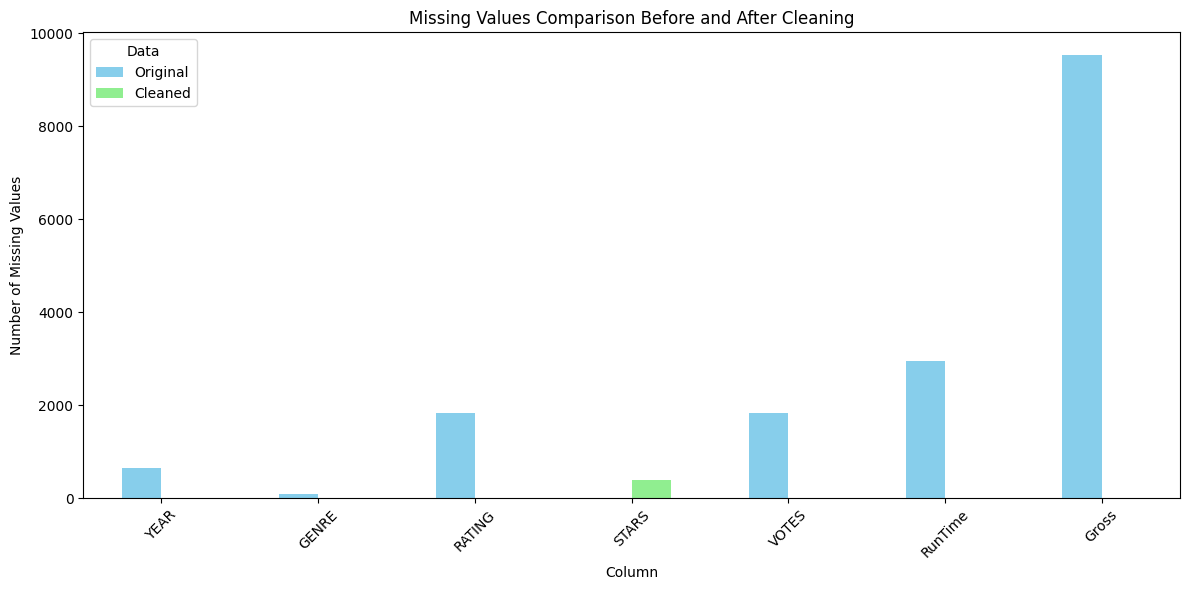

✅ Missing Value Comparison plot generated.
--- Finished plot_missing_values_comparison ---
--- Calling plot_numeric_distribution_comparison ---

📊 Plotting Distribution Comparison for 'RunTime'...


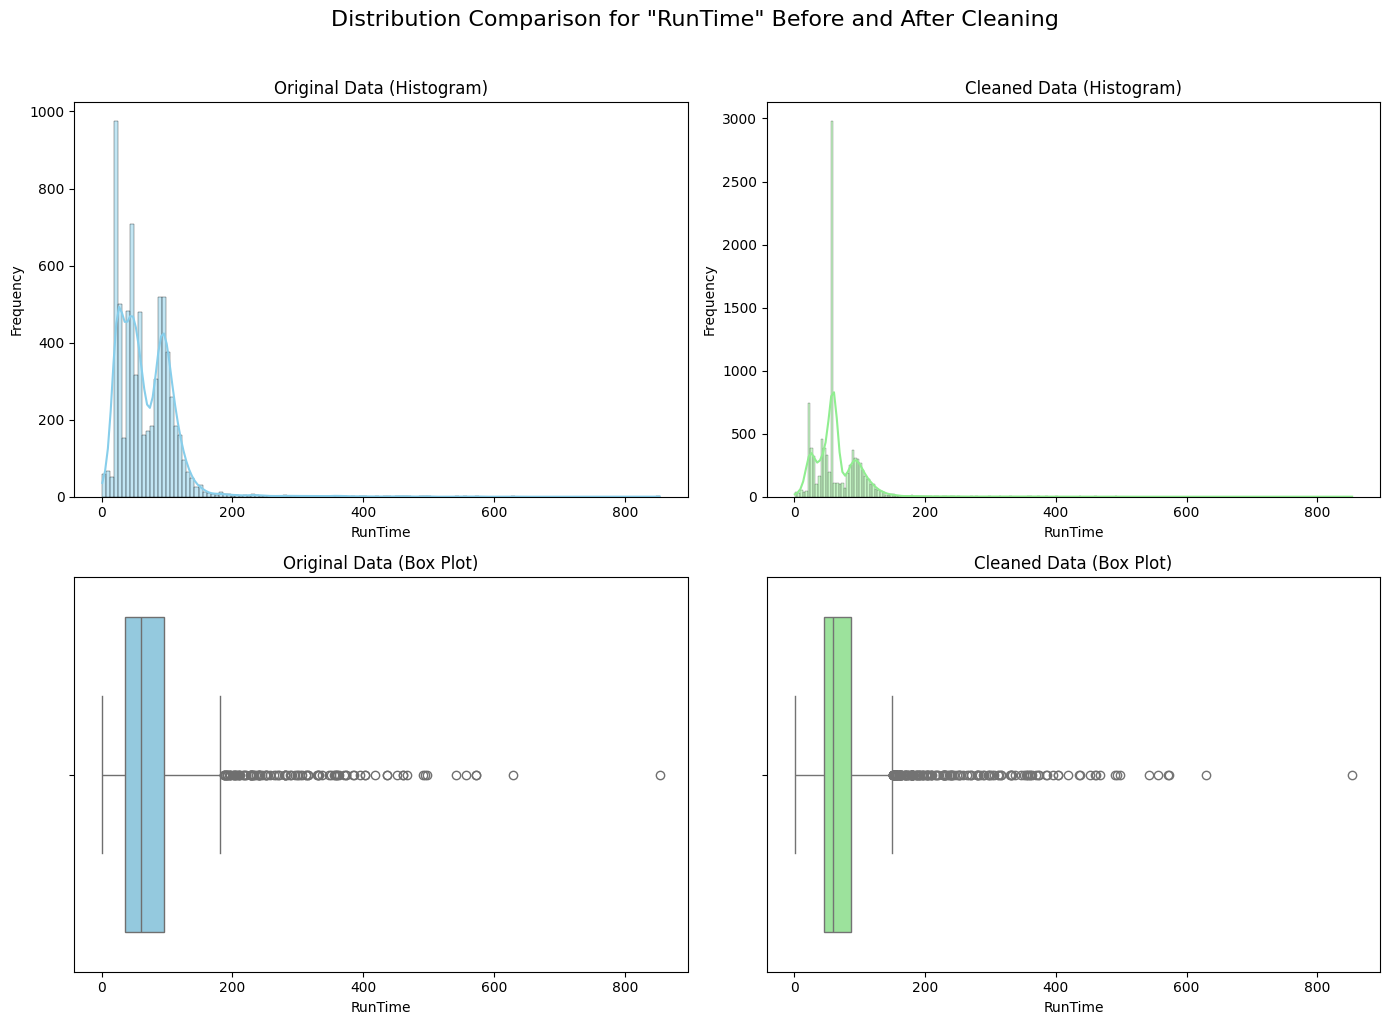

✅ Distribution Comparison plot generated for 'RunTime'.

📊 Plotting Distribution Comparison for 'RATING'...


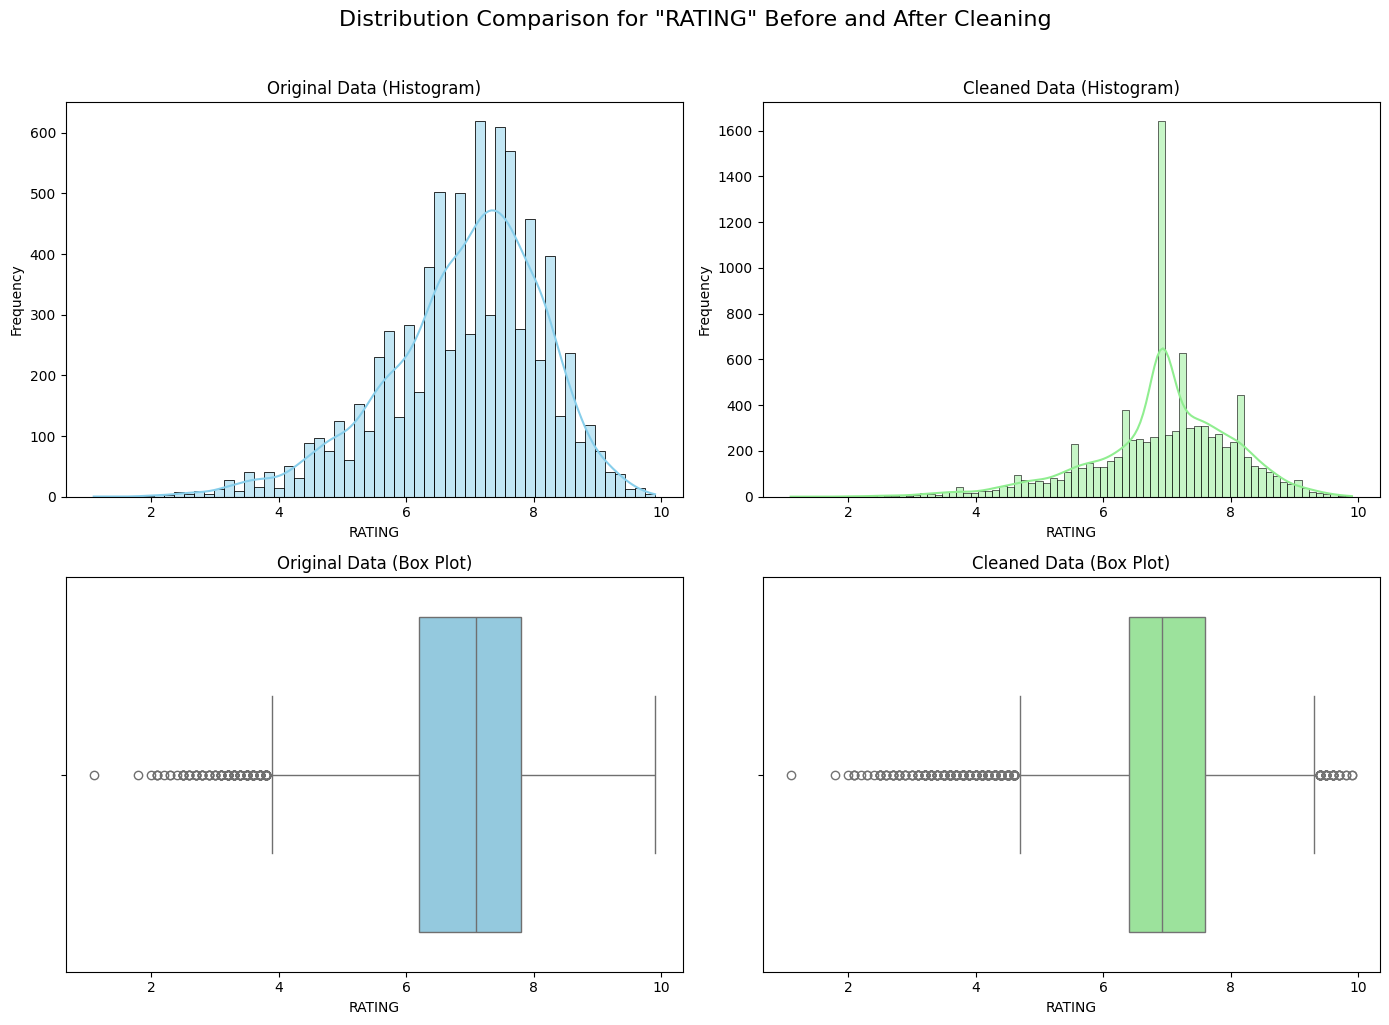

✅ Distribution Comparison plot generated for 'RATING'.
--- Finished plot_numeric_distribution_comparison ---
--- Calling plot_categorical_distribution_comparison ---

📊 Plotting Categorical Distribution Comparison for 'STARS'...


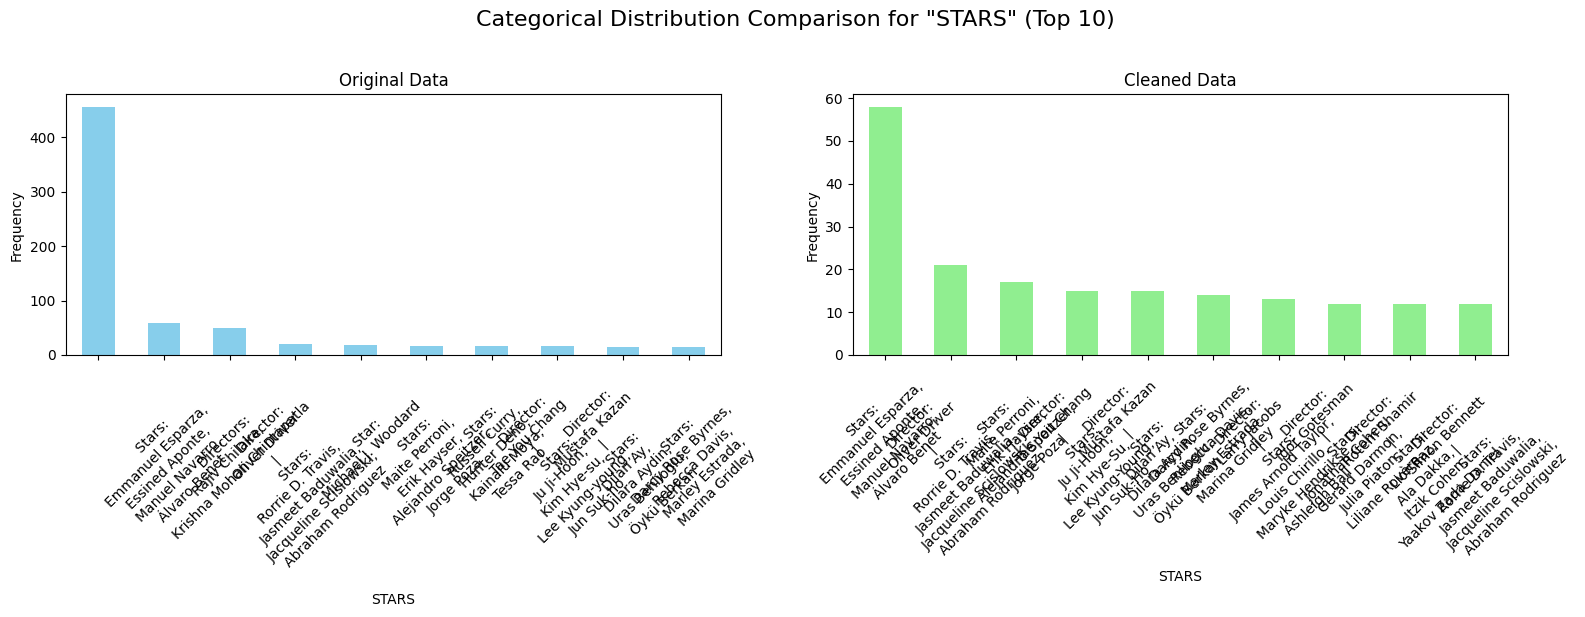

✅ Categorical Distribution Comparison plot generated for 'STARS'.

📊 Plotting Categorical Distribution Comparison for 'VOTES'...


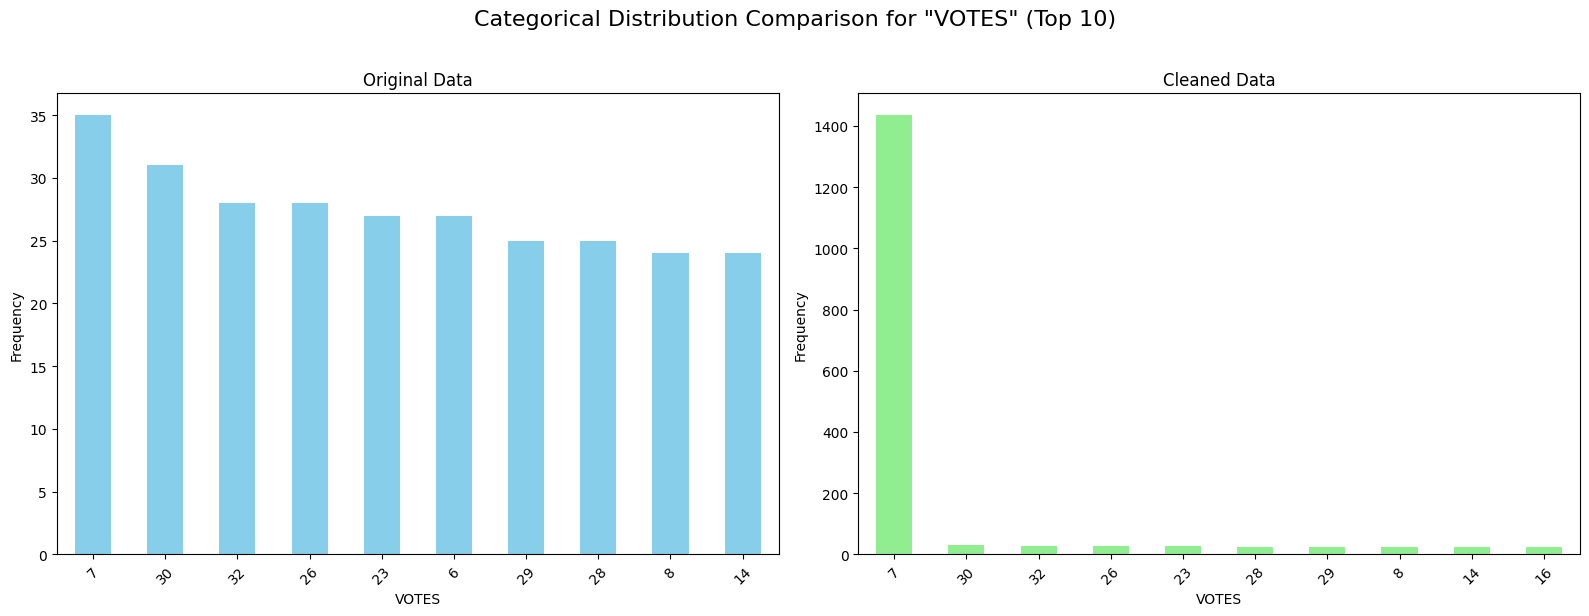

✅ Categorical Distribution Comparison plot generated for 'VOTES'.

📊 Plotting Categorical Distribution Comparison for 'Gross'...


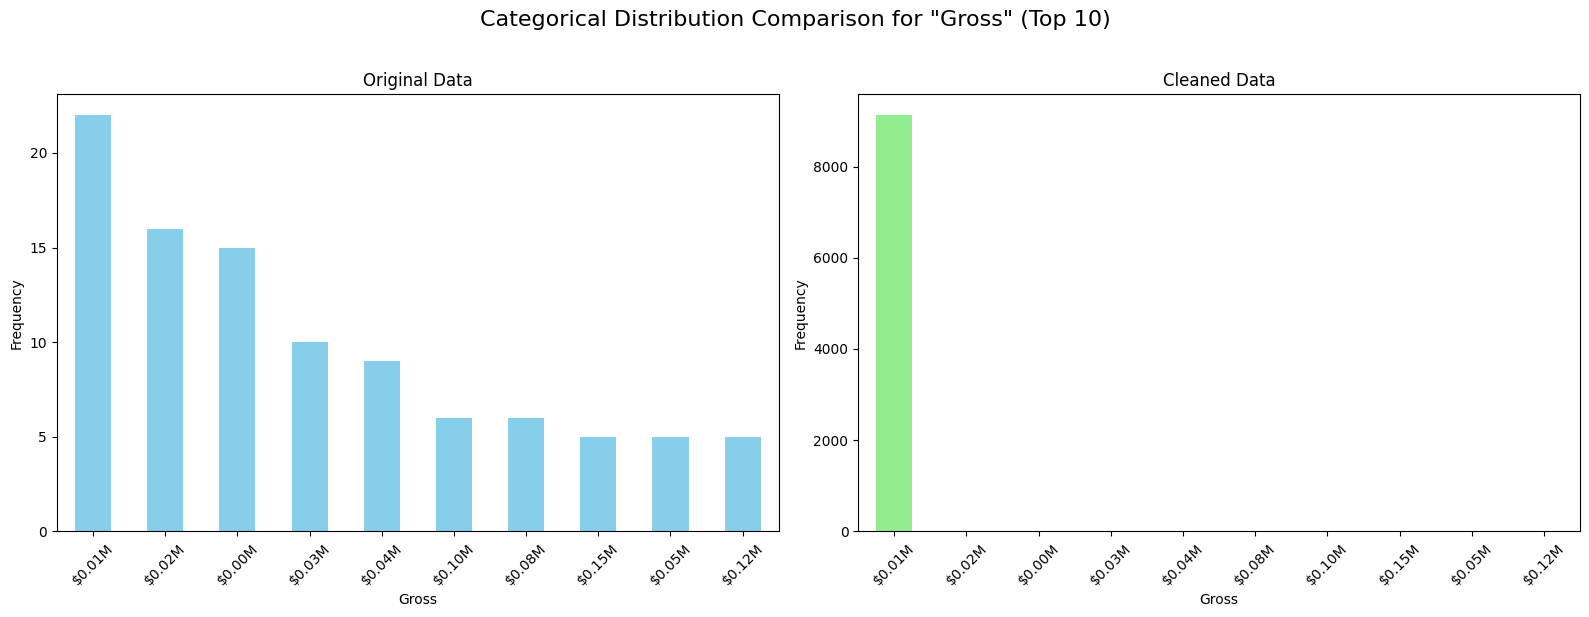

✅ Categorical Distribution Comparison plot generated for 'Gross'.
--- Finished plot_categorical_distribution_comparison ---
--- Calling display_sample_comparison ---

📋 Displaying Sample Data Comparison:

--- Original Data Sample ---


,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.1,\nA woman with a mysterious illness is forced ...,\n Director:\nPeter Thorwarth\n| \n Star...,"21,062",121.0,NaN
1,Masters of the Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...","17,870",25.0,NaN
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,"\n \n Stars:\nAndrew Lincoln, \n...","885,805",44.0,NaN
3,Rick and Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.2,\nAn animated series that follows the exploits...,"\n \n Stars:\nJustin Roiland, \n...","414,849",23.0,NaN
4,Army of Thieves,(2021),"\nAction, Crime, Horror",NaN,"\nA prequel, set before the events of Army of ...",\n Director:\nMatthias Schweighöfer\n| \n ...,NaN,NaN,NaN



--- Cleaned Data Sample ---


,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.100000,A Woman With A Mysterious Illness Is Forced In...,Director:\nPeter Thorwarth\n| \n Stars:\nPe...,"21,062",121.0,$0.01M
1,Masters Of The Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.000000,The War For Eternia Begins Again In What May B...,"Stars:\nChris Wood, \nSarah Michelle Gellar, \...","17,870",25.0,$0.01M
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.200000,Sheriff Deputy Rick Grimes Wakes Up From A Com...,"Stars:\nAndrew Lincoln, \nNorman Reedus, \nMel...","885,805",44.0,$0.01M
3,Rick And Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.200000,An Animated Series That Follows The Exploits O...,"Stars:\nJustin Roiland, \nChris Parnell, \nSpe...","414,849",23.0,$0.01M
4,Army Of Thieves,(2021),"\nAction, Crime, Horror",6.921176,"A Prequel, Set Before The Events Of Army Of Th...",Director:\nMatthias Schweighöfer\n| \n Star...,7,60.0,$0.01M



✅ Sample data comparison displayed.
--- Finished display_sample_comparison ---
✅ All comparison visualizations generated.


In [13]:
# Load the original and cleaned datasets
original_file_path = '/content/movies.csv'
cleaned_file_path = '/content/cleaned_data.csv'

try:
    original_df = pd.read_csv(original_file_path)
    cleaned_df_from_file = pd.read_csv(cleaned_file_path)

    print(f"\n📁 Successfully loaded original dataset: {original_file_path}")
    print(f"📊 Original data: {original_df.shape[0]} rows × {original_df.shape[1]} columns")
    display(original_df.head())

    print(f"\n📁 Successfully loaded cleaned dataset: {cleaned_file_path}")
    print(f"📊 Cleaned data: {cleaned_df_from_file.shape[0]} rows × {cleaned_df_from_file.shape[1]} columns")
    display(cleaned_df_from_file.head())

    # Generate visualizations comparing original and cleaned data
    print("\nGenerating Cleaning Visualizations comparing Original and Cleaned data...")

    # 1. Missing Values Comparison
    print("--- Calling plot_missing_values_comparison ---")
    plot_missing_values_comparison(original_df, cleaned_df_from_file)
    print("--- Finished plot_missing_values_comparison ---")

    # 2. Numeric Distribution Comparison
    numeric_cols_to_plot = list(
        set(original_df.select_dtypes(include=np.number).columns) &
        set(cleaned_df_from_file.select_dtypes(include=np.number).columns)
    )[:3]  # first 3 numeric columns

    if numeric_cols_to_plot:
        print("--- Calling plot_numeric_distribution_comparison ---")
        for col in numeric_cols_to_plot:
            plot_numeric_distribution_comparison(original_df, cleaned_df_from_file, col)
        print("--- Finished plot_numeric_distribution_comparison ---")
    else:
        print("ℹ️ No common numeric columns found to plot.")

    # 3. Categorical Distribution Comparison
    categorical_cols_to_plot = list(
        set(original_df.select_dtypes(include=['object', 'category']).columns) &
        set(cleaned_df_from_file.select_dtypes(include=['object', 'category']).columns)
    )[:3]  # first 3 categorical columns

    if categorical_cols_to_plot:
        print("--- Calling plot_categorical_distribution_comparison ---")
        for col in categorical_cols_to_plot:
            plot_categorical_distribution_comparison(original_df, cleaned_df_from_file, col)
        print("--- Finished plot_categorical_distribution_comparison ---")
    else:
        print("ℹ️ No common categorical columns found to plot.")

    # 4. Display Sample Comparison
    print("--- Calling display_sample_comparison ---")
    display_sample_comparison(original_df, cleaned_df_from_file, num_samples=5)
    print("--- Finished display_sample_comparison ---")

    print("✅ All comparison visualizations generated.")

except FileNotFoundError as e:
    print(f"❌ Error: File not found - {e}. Please check the file paths.")
except Exception as e:
    print(f"❌ An error occurred: {e}")
